In [103]:
#import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime

# Exercise 3

### Question A

In [104]:
x = np.array([[0, 0],
              [0, 1],
              [1, 0],
              [1, 1]])

y = np.array([[0],
              [1],
              [1],
              [0]])

In [105]:
df = pd.DataFrame(np.concatenate((x, y), axis=1), columns=('x1', 'x2', 'y'))
df.style.hide()

x1,x2,y
0,0,0
0,1,1
1,0,1
1,1,0


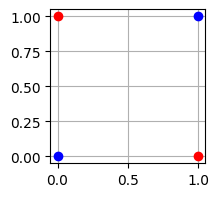

In [106]:
plt.figure(figsize=(2,2))

plt.plot(*x[0], 'o', color='blue')
plt.plot(*x[1], 'o', color='red')
plt.plot(*x[2], 'o', color='red')
plt.plot(*x[3], 'o', color='blue')
plt.grid()

plt.show()

In [107]:
class NeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size, one_hot=False, activation_function='reLU'):
        # Initialize number of nodes of input, hidden, and output layer
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.accuracies = [] # Initialize accuracies


        # Initialize weights (w) and biases (b)
        # input -> hidden
        self.w1 = np.random.rand(self.input_size, self.hidden_size) # 35*10
        self.b1 = np.zeros((1, self.hidden_size)) # 1*10

        # hidden -> output
        self.w2 = np.random.rand(self.hidden_size, self.output_size) # 10*1
        self.b2 = np.zeros((1, self.output_size)) # 1*1

        #adam parameters
        self.beta1 = 0.9
        self.beta2 = 0.999
        self.epsilon = 1e-8

        # Increment the time step
        self.t =0
        
        # Activation function
        self.activation_function = activation_function
        
        # Use of one_hot encoding
        self.one_hot = one_hot
        
       # Initialize moving average variables for weights
        self.m_w1 = np.zeros_like(self.w1)
        self.v_w1 = np.zeros_like(self.w1)
        self.m_w2 = np.zeros_like(self.w2)
        self.v_w2 = np.zeros_like(self.w2)

        # Initialize moving average variables for biases
        self.m_b1 = np.zeros_like(self.b1)
        self.v_b1 = np.zeros_like(self.b1)
        self.m_b2 = np.zeros_like(self.b2)
        self.v_b2 = np.zeros_like(self.b2)

        # Record data
        self.losses = []
    
   
    def activation(self, x, activation_function, deriv=False):
        """Activation function (sigmoid, reLU, softmax)"""
        if activation_function == 'sigmoid':
            if deriv:
                return self.activation(x, activation_function) * (1 - self.activation(x, activation_function))
            return 1 / (1 + np.exp(-x))
        elif activation_function == 'reLU':
            return np.maximum(0, x)
        elif activation_function == 'softmax':
            """Stable softmax activation function"""
            e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
            return e_x / np.sum(e_x, axis=1, keepdims=True)


    def one_hot_encoding(self, y):
        """Encode digit to one-hot (used in error calculation of backpropagation)"""
        y = y.reshape(-1, 10)
        encoded_y = np.zeros((y.size, y.max() + 1))
        encoded_y[np.arange(y.size), y.flatten()] = 1
        encoded_y = encoded_y.T
        return encoded_y


    def feedforward(self, x):
        """Feedforward"""
        # input -> hidden
        self.z1 = np.dot(x, self.w1) + self.b1 # 10*35 @ 35*10 = 10*10
        self.a1 = self.activation(self.z1, 'reLU')



        # hidden -> output
        self.z2 = np.dot(self.a1, self.w2) + self.b2 # 10*10 @ 10*1 = 10*1
        self.a2 = self.activation(self.z2, 'reLU') # 10*1


        return self.a2


    def backpropagation(self, x, y, learning_rate):
        """Backpropagation"""        
        self.m = y.size
        
        self.d_z2 = self.a2 - y # 10*1
        self.d_w2 = np.dot(self.a1.T, self.d_z2) / self.m # 10*10 @ 10*1 = 10*1
        self.d_b2 = np.sum(self.d_z2) / self.m # 1*1
        
        self.d_z1 = np.dot(self.d_z2, self.w2.T) * self.activation(self.z1, self.activation_function, deriv=True) # 10*1 @ 1*10
        self.d_w1 = np.dot(x.T, self.d_z1) / self.m
        self.d_b1 = np.sum(self.d_z1) / self.m

        #updating adam parameters m = beta1 * m + (1 - beta1) * d_ and v = beta2 * v + (1 - beta2) * (d_ ** 2)
        self.m_w1 = self.beta1 * self.m_w1 + (1 - self.beta1) * self.d_w1
        self.v_w1 = self.beta2 * self.v_w1 + (1 - self.beta2) * (self.d_w1 ** 2)
        self.m_b1 = self.beta1 * self.m_b1 + (1 - self.beta1) * self.d_b1
        self.v_b1 = self.beta2 * self.v_b1 + (1 - self.beta2) * (self.d_b1 ** 2)
        self.m_w2 = self.beta1 * self.m_w2 + (1 - self.beta1) * self.d_w2
        self.v_w2 = self.beta2 * self.v_w2 + (1 - self.beta2) * (self.d_w2 ** 2)
        self.m_b2 = self.beta1 * self.m_b2 + (1 - self.beta1) * self.d_b2
        self.v_b2 = self.beta2 * self.v_b2 + (1 - self.beta2) * (self.d_b2 ** 2)

        #bias corrections average
        m_w1_hat = self.m_w1 / (1 - self.beta1)
        v_w1_hat = self.v_w1 / (1 - self.beta2)
        m_b1_hat = self.m_b1 / (1 - self.beta1)
        v_b1_hat = self.v_b1 / (1 - self.beta2)
        m_w2_hat = self.m_w2 / (1 - self.beta1)
        v_w2_hat = self.v_w2 / (1 - self.beta2)
        m_b2_hat = self.m_b2 / (1 - self.beta1)
        v_b2_hat = self.v_b2 / (1 - self.beta2)

        #updating bias and weights 
        self.w1 -= m_w1_hat * learning_rate /(np.sqrt(v_w1_hat)+ self.epsilon)
        self.b1 -= m_b1_hat * learning_rate /(np.sqrt(v_b1_hat)+ self.epsilon)
        self.w2 -= m_w2_hat * learning_rate /(np.sqrt(v_w2_hat)+ self.epsilon)
        self.b2 -= m_b2_hat * learning_rate /(np.sqrt(v_b2_hat)+ self.epsilon)

    

    def train(self, x, y, learning_rate, epochs):
        """Optimize weight and bias parameters for adam""" 
        self.input = x
        self.output = y
        self.learning_rate = learning_rate
        self.epochs = epochs

        if self.one_hot:
            y = self.one_hot_encoding(y)

        for epoch in range(epochs):
            self.feedforward(x)
            self.backpropagation(x, y, learning_rate)

            # Calculate accuracy
            #predictions = (self.predict(x) > 0.5).astype(int)  # Convert to integers
            predictions = np.round(self.predict(x))  
            accuracy = np.mean(predictions == y)
            self.accuracies.append(accuracy)  # Store accuracy
            
            if not epoch % (epochs / 10):
                loss = self.cross_entropy_loss(y, self.a2)
                self.losses.append(loss)
                print(f'Epoch {epoch}: {loss}')
            
            self.update_adam()


    def cross_entropy_loss(self, y_true, y_pred):
        """Calculate categorical cross-entropy loss"""
        epsilon = 1e-10  # Small value to prevent log(0) cases
        y_pred_clipped = np.clip(y_pred, epsilon, 1 - epsilon)  # Clip predictions to avoid log(0)
        m = y_true.shape[0]  # Number of examples
        loss = -np.sum(y_true * np.log(y_pred_clipped)) / m
        return loss

    def update_adam(self):
        # Update variables
        self.m_w1 = self.beta1 * self.m_w1 + (1 - self.beta1) * self.d_w1
        self.v_w1 = self.beta2 * self.v_w1 + (1 - self.beta2) * (self.d_w1 ** 2)
        self.m_b1 = self.beta1 * self.m_b1 + (1 - self.beta1) * self.d_b1
        self.v_b1 = self.beta2 * self.v_b1 + (1 - self.beta2) * (self.d_b1 ** 2)
        self.m_w2 = self.beta1 * self.m_w2 + (1 - self.beta1) * self.d_w2
        self.v_w2 = self.beta2 * self.v_w2 + (1 - self.beta2) * (self.d_w2 ** 2)
        self.m_b2 = self.beta1 * self.m_b2 + (1 - self.beta1) * self.d_b2
        self.v_b2 = self.beta2 * self.v_b2 + (1 - self.beta2) * (self.d_b2 ** 2)
    

        self.t += 1 
        
        # Bias correction for m and v variables
        self.m_w1_hat = self.m_w1 / (1 - self.beta1 ** self.t)
        self.m_w2_hat = self.m_w2 / (1 - self.beta1 ** self.t)
        self.m_b1_hat = self.m_b1 / (1 - self.beta1 ** self.t)
        self.m_b2_hat = self.m_b2 / (1 - self.beta1 ** self.t)
        self.v_w1_hat = self.v_w1 / (1 - self.beta2 ** self.t)
        self.v_w2_hat = self.v_w2 / (1 - self.beta2 ** self.t)
        self.v_b1_hat = self.v_b1 / (1 - self.beta2 ** self.t)
        self.v_b2_hat = self.v_b2 / (1 - self.beta2 ** self.t)

    
        # Update weights and biases with bias correction
        self.w1 -= self.m_w1_hat * learning_rate / (np.sqrt(self.v_w1_hat) + self.epsilon)
        self.w2 -= self.m_w2_hat * learning_rate / (np.sqrt(self.v_w2_hat) + self.epsilon)
        self.b1 -= self.m_b1_hat * learning_rate / (np.sqrt(self.v_b1_hat) + self.epsilon)
        self.b2 -= self.m_b2_hat * learning_rate / (np.sqrt(self.v_b2_hat) + self.epsilon)
        
    def predict(self, x):
        """Get feedforward result with current parameters"""
        return self.feedforward(x)
        
    def graph(self, graph_type, name=None, xlim=None):
        """Graph information about neural network performance"""
        
        # Check graph type
        if graph_type is None:
            raise ValueError('Unknown graph type')
        
        # Generate name if no name is given
        if name is None:
            name = datetime.now().strftime('%Y_%m_%d_%H_%M_%S_%f')
    
        # Add parameter box for plot
        parameters = (
            'Parameters\n\n'
            f'Input nodes: {self.input_size}\n'
            f'Hidden nodes: {self.hidden_size}\n'
            f'Output nodes: {self.output_size}\n'
            f'Learning rate: {self.learning_rate}\n'
            f'Activation function: {self.activation_function}\n'
            f'Epochs: {self.epochs}'
        )
    
        fig, (ax1, ax2) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [8, 1]}, figsize=(7.2, 4.8))
        ax2.text(-0.2, 0.7, parameters, bbox=dict(facecolor='white', alpha=0.5), transform=ax2.transAxes)
        ax2.axis('off')
    
        # Set x-axis limits
        if xlim is not None:
            ax1.set_xlim(xlim)
    
        # Plot loss vs epoch
        if graph_type == 'loss_epoch':
            ax1.plot(self.losses)            
            ax1.set_title('Loss vs epoch')
            ax1.set_xlabel('Epoch')
            ax1.set_ylabel('Loss')
            ax1.grid()
            fig.savefig(f'./graphs/loss_{name}', dpi=300)
    
        # Plot accuracy vs epoch 
        if graph_type == 'accuracy_epoch':
            ax1.plot(self.accuracies) 
            ax1.set_title('Accuracy vs Epoch') 
            ax1.set_xlabel('Epoch') 
            ax1.set_ylabel('Accuracy')
            ax1.grid() 
            fig.savefig(f'./graphs/accuracy_{name}', dpi=300)
    
        # Plot confusion matrix
        elif graph_type == 'confusion':
            matrix = np.array([self.feedforward(value).squeeze() for value in self.input]).T
            normalized_matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]  # Normalize confusion matrix
            im = ax1.matshow(normalized_matrix, cmap='viridis')

    
    
            for i in range(matrix.shape[0]):                
                for j in range(matrix.shape[1]):
                    ax1.text(j, i, f'{np.round(matrix[i, j], 2)}', ha='center', va='center', color='white', size='8')
    
            ax1.set_title('Confusion matrix')
            ax1.set_xlabel('Predicted digit')
            ax1.set_ylabel('Real digit')
            ax1.set_xticks(np.arange(len(self.input)))
            ax1.set_yticks(np.arange(len(self.input)))
            fig.colorbar(im, ax=ax1)
            fig.savefig(f'./graphs/confusion_{name}', dpi=300);


In [108]:
learning_rate = 0.0001
epochs = 10000
nn_A = NeuralNetwork(2, 2, 1)
nn_A.train(x, y, learning_rate, epochs)
nn_A.predict(x)

Epoch 0: 0.02857470935411315
Epoch 1000: 0.2943307880052731
Epoch 2000: 0.5400051425922117
Epoch 3000: 0.587565607515638
Epoch 4000: 0.5735604248095876
Epoch 5000: 0.5312164571592113
Epoch 6000: 0.4369091443283865
Epoch 7000: 0.36204212172710304
Epoch 8000: 0.3309977592222016
Epoch 9000: 0.3246562395817721


array([[0.35675565],
       [0.78612649],
       [0.35675565],
       [0.49953058]])

### Question B

Load raw data

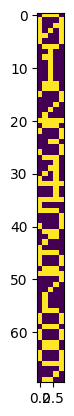

In [109]:
data = np.loadtxt("TP3-ej3-digitos.txt", dtype=np.uint8) 
plt.imshow(data);

Flatten data

In [110]:
data_flattened = data.flatten()
data_flattened = np.reshape(data_flattened, (10, 35))

print(data_flattened.shape)
data_flattened

(10, 35)


array([[0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1,
        0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0],
       [0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0],
       [0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
        1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1],
       [0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0,
        0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0],
       [0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1,
        1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0],
       [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0],
       [0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0,
        0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0],
       [1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 1, 1, 1, 0, 1

Initialize x input (flattened digit) and y output (result of whether digit is pair)

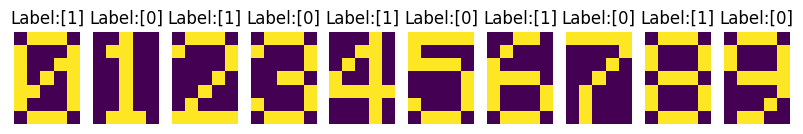

In [111]:
x = data_flattened
y = np.array([1, 0, 1, 0, 1, 0, 1, 0, 1, 0]).reshape(-1, 1)

plt.figure(figsize=(10, 3))
for i, img in enumerate(data_flattened):
    plt.subplot(1, 10, i+1)
    plt.title('Label:' + str(y[i]))
    plt.axis('off')
    plt.imshow(np.reshape(img, (7,5)))

In [112]:
input_size = 35
hidden_size = 10
output_size = 1

learning_rate = 0.0001
epochs = 10000

nn_B = NeuralNetwork(input_size, hidden_size, output_size)
nn_B.train(x, y, learning_rate, epochs)
nn_B.predict(x)

Epoch 0: 5.000000413951855e-11
Epoch 1000: 5.000000413951855e-11
Epoch 2000: 5.000000413951855e-11
Epoch 3000: 5.000000413951855e-11
Epoch 4000: 5.000000413951855e-11
Epoch 5000: 5.000000413951855e-11
Epoch 6000: 0.05461994527259727
Epoch 7000: 0.21994061194365178
Epoch 8000: 0.10814896626743316
Epoch 9000: 0.05625439717579504


array([[0.98299797],
       [0.        ],
       [0.98934777],
       [0.18624647],
       [0.99649823],
       [0.        ],
       [1.06113415],
       [0.        ],
       [0.8082728 ],
       [0.03116785]])

digit is even: [[0.03116785]]


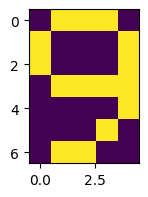

In [113]:
digit = 9

plt.figure(figsize=(2,2))
plt.imshow(np.reshape(data_flattened[digit], (7,5)));
res = nn_B.predict(data_flattened[digit])
print('digit is even:', res)

In [114]:
threshold = 0.5
res = nn_B.predict(data_flattened[digit])
is_even = res > threshold
print(f'The digit is even: {is_even}')

The digit is even: [[False]]


### Exercise C

Initialize data
- x: 10*35 (10 digits * 35 pixels each)
- y: 10*1 (can be classified to 10 possible digits)

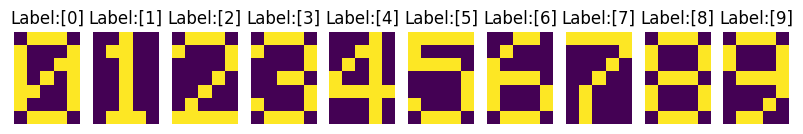

In [115]:
x = data_flattened
y = np.arange(10).reshape(-1, 1)


plt.figure(figsize=(10, 3))
for i, img in enumerate(data_flattened):
    plt.subplot(1, 10, i+1)
    plt.title('Label:' + str(y[i]))
    plt.axis('off')
    plt.imshow(np.reshape(img, (7,5)))

In [116]:
input_size = 35
hidden_size = 10
output_size = 10

learning_rate = 0.00002
epochs = 100000

nn_C = NeuralNetwork(input_size, hidden_size, output_size, one_hot=True, activation_function='reLU')
nn_C.train(x, y, learning_rate, epochs)
nn_C.predict(x)

Epoch 0: 1.000000082790371e-10
Epoch 10000: 1.000000082790371e-10
Epoch 20000: 7.313599746086832
Epoch 30000: 0.03390433806892486
Epoch 40000: 3.995462390058239e-05
Epoch 50000: 6.680110261164588e-05
Epoch 60000: 5.354188928175646e-05
Epoch 70000: 1.2524604629424186e-05
Epoch 80000: 2.9836088236303074e-05
Epoch 90000: 4.3475880301360635e-05


array([[1.00014541, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.99997954, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 1.00015235, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 1.00004687, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 1.00002707,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        1.0001328 , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.99985207, 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.       

[[0.         0.         0.         0.         0.         0.
  0.99985207 0.         0.         0.        ]]
digit is: 6


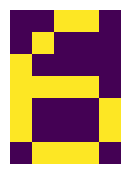

In [117]:
digit = 6

plt.figure(figsize=(2,2))
plt.axis('off')
plt.imshow(np.reshape(data_flattened[digit], (7,5)));
res = nn_C.predict(data_flattened[digit])
print(res)
print('digit is:', np.argmax(res))

In [118]:
def salt_pepper_noise(img, salt_probability, pepper_probability):
    img_copy = np.copy(img)
    salt = np.random.rand(img.size) < salt_probability
    pepper = np.random.rand(img.size) < pepper_probability
    img_copy[salt] = 1
    img_copy[pepper] = 0
    return img_copy

def random_noise(img):
    img_copy = np.copy(img)
    img_copy = img_copy + np.random.rand(img_copy.size)
    return img_copy

def gaussian_noise(img, mean, std):
    img_copy = np.copy(img)
    img_copy = img_copy + np.random.normal(mean, std, img_copy.size)
    return img_copy

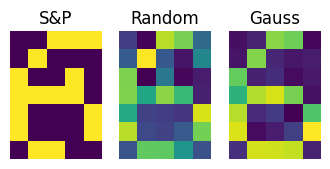

In [119]:
salt_pepper_digit = salt_pepper_noise(data_flattened[digit], 0.05, 0.05)
random_digit = random_noise(data_flattened[digit])
gauss_digit = gaussian_noise(data_flattened[digit], 0.1, 0.1)

noised_data = [salt_pepper_digit, random_digit, gauss_digit]
titles = ['S&P', 'Random', 'Gauss']

plt.figure(figsize=(4,3))
for i, img in enumerate(noised_data):
    plt.subplot(1, 3, i+1)
    plt.title(titles[i])
    plt.axis('off')
    plt.imshow(np.reshape(img, (7,5)));

In [120]:
np.argmax(nn_C.predict(random_digit))

6

In [121]:
#analyzing

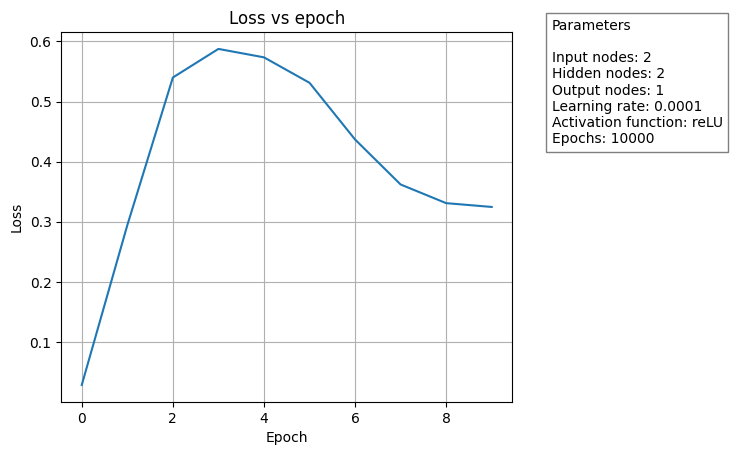

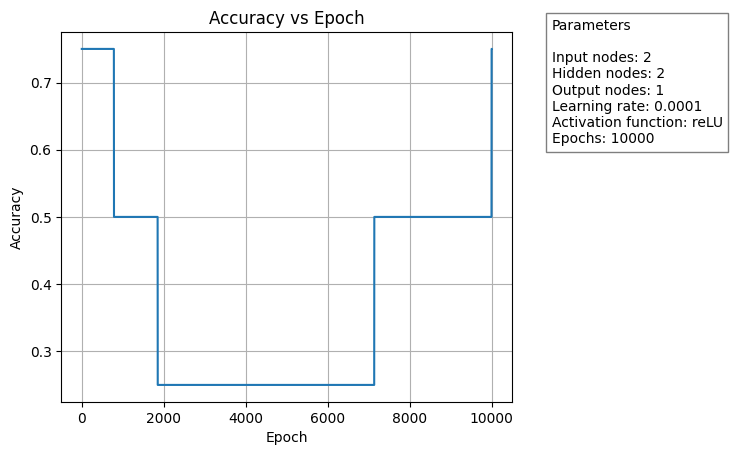

In [122]:
nn_A.graph('loss_epoch')
nn_A.graph(graph_type='accuracy_epoch')

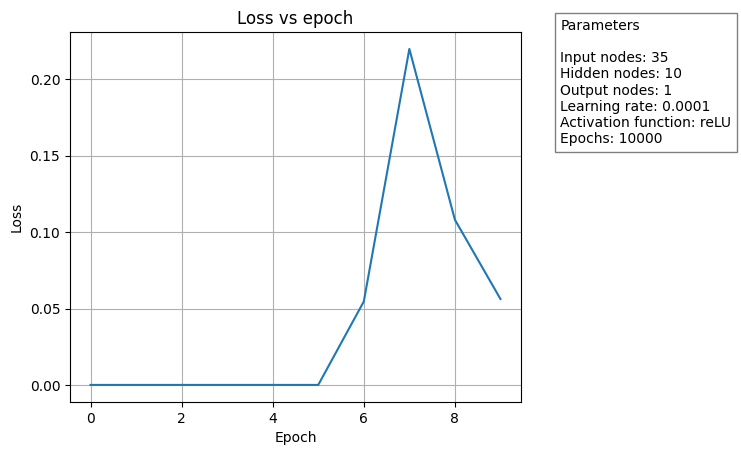

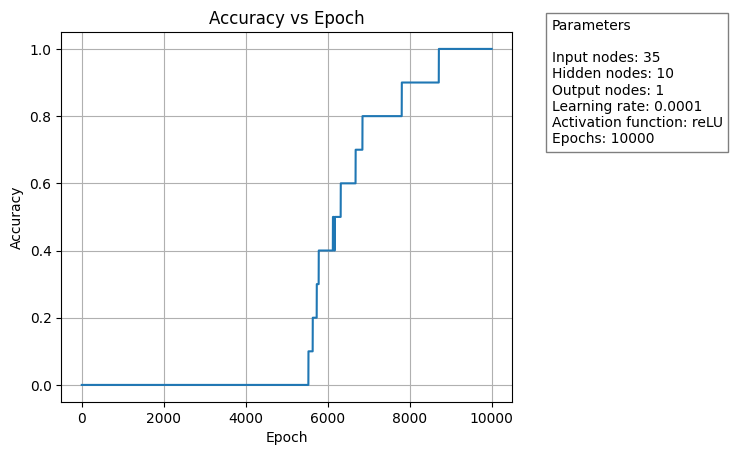

In [123]:
nn_B.graph('loss_epoch')
nn_B.graph(graph_type='accuracy_epoch')

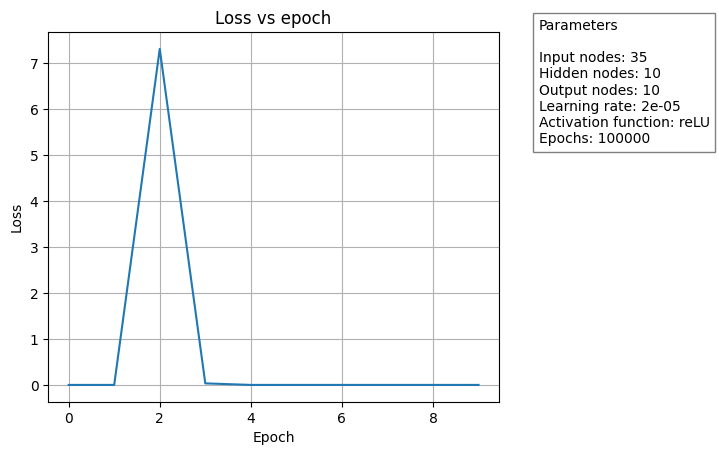

In [124]:
nn_C.graph('loss_epoch')

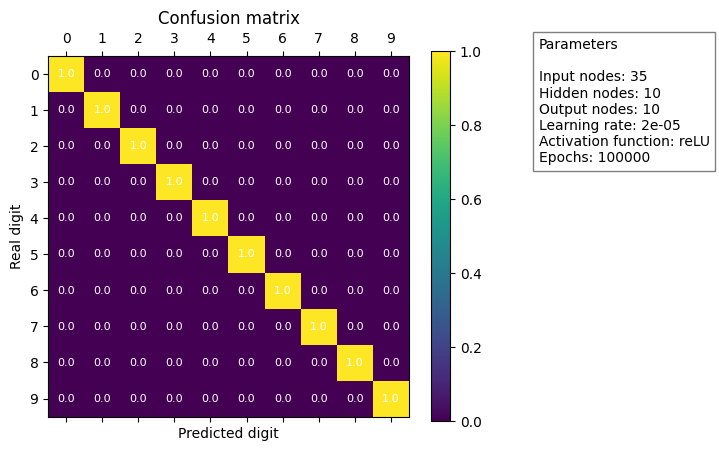

In [125]:
nn_C.graph(graph_type='confusion')